# 亮度调节

In [1]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
def load_kernel(src,kname):
    _ = cp.zeros((1,)) # 初始化cuda context
    kernel = cp.core.core.compile_with_cache(src).get_function(kname)
    return kernel

In [5]:
sources = string.Template("""
extern "C"{
__global__ void auto_wb_blance(int *In, int *Out, double rgb, int Width, int Height)
{

    int y = blockDim.y * blockIdx.y + threadIdx.y;
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    if (x <= Width && x >= 0 && y <= Height && y >= 0)
    {
        Out[y* Width + x] = In[y* Width + x]*rgb;
     }
}

}
""").substitute()

In [21]:
src = cv2.cvtColor(cv2.imread('../../datas/f2.jpg'),cv2.COLOR_BGR2GRAY)

In [25]:
auto_wb_blance = load_kernel(sources,'auto_wb_blance')

In [26]:
height,width= src.shape
dim_block = (32,32)
grid = ((dim_block[0] + width - 1) // dim_block[0],
        (dim_block[1] + height - 1) // dim_block[1])
src_cu = cp.asarray(src).astype(cp.int32)
dst_cu = cp.zeros(src.shape,dtype=cp.int32)

In [27]:
auto_wb_blance(grid=grid,block=dim_block,args=(src_cu,dst_cu,1.2,width,height))

In [28]:
dst = dst_cu.get()
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = np.uint8(np.abs(dst))

([], <a list of 0 Text yticklabel objects>)

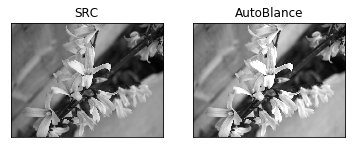

In [29]:
plt.subplot(121)
plt.imshow(src,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('AutoBlance')
plt.xticks([])
plt.yticks([])